# **Data Cleaning**

In [1]:
import copy
import re
import json
import math
from xml.sax.handler import feature_external_ges

import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

from collections import Counter
from scipy import sparse
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

In [2]:
df_colognes = pd.read_csv('../../data/interim/fra_cleaned.csv', sep=';', encoding='ISO-8859-1')
df_notes = pd.read_csv('../../data/interim/notes.csv', sep=',', encoding='ISO-8859-1')

In [3]:
df_colognes

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,Perfumer2,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,https://www.fragrantica.com/perfume/xerjoff/ac...,accento-overdose-pride-edition,xerjoff,Italy,unisex,"1,42",201,2022.0,"fruity notes, aldehydes, green notes","bulgarian rose, egyptian jasmine, lily-of-the-...","eucalyptus, pine",unknown,NaN,rose,woody,fruity,aromatic,floral
1,https://www.fragrantica.com/perfume/jean-paul-...,classique-pride-2024,jean-paul-gaultier,France,women,"1,86",70,2024.0,"yuzu, citruses","orange blossom, neroli","musk, blonde woods",unknown,NaN,citrus,white floral,sweet,fresh,musky
2,https://www.fragrantica.com/perfume/jean-paul-...,classique-pride-2023,jean-paul-gaultier,France,unisex,"1,91",285,2023.0,"blood orange, yuzu","neroli, orange blossom","musk, white woods",natalie gracia-cetto,quentin bisch,citrus,white floral,sweet,fresh spicy,musky
3,https://www.fragrantica.com/perfume/bruno-bana...,pride-edition-man,bruno-banani,Germany,men,"1,92",59,2019.0,"guarana, grapefruit, red apple","walnut, lavender, guava","vetiver, benzoin, amber",unknown,NaN,fruity,nutty,woody,tropical,NaN
4,https://www.fragrantica.com/perfume/jean-paul-...,le-male-pride-collector,jean-paul-gaultier,France,men,"1,93",632,2020.0,"mint, lavender, cardamom, artemisia, bergamot","caraway, cinnamon, orange blossom","vanilla, sandalwood, amber, cedar, tonka bean",francis kurkdjian,NaN,aromatic,warm spicy,fresh spicy,cinnamon,vanilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24058,https://www.fragrantica.com/perfume/o-boticari...,floratta,o-boticario,Brazil,women,"4,81",31,1992.0,"ozonic notes, peach","lily-of-the-valley, jasmine","musk, amber",thierry lecoule,NaN,white floral,ozonic,fresh,musky,powdery
24059,https://www.fragrantica.com/perfume/sultan-pas...,cheval-d-arabie,sultan-pasha-attars,UK,unisex,"4,81",26,2020.0,"taif rose, indian oud, white rose, olibanum, e...","bulgarian rose, indian oud, hay, leather, cive...","white amber, leather, hay, elemi resin, kyara ...",sultan pasha,NaN,rose,amber,fresh spicy,animalic,aromatic
24060,https://www.fragrantica.com/perfume/darkbeat-p...,khaox,darkbeat-parfums,Spain,unisex,"4,85",26,2020.0,"mint, lime, rum","lily-of-the-valley, fig leaf, cardamom","musk, oakmoss, amber, patchouli",josé m. giraldo,NaN,green,aromatic,citrus,fresh spicy,woody
24061,https://www.fragrantica.com/perfume/parfumerie...,aoud-no-1,parfumerie-bruckner,Germany,unisex,"4,86",28,2011.0,"apple, peach, saffron","plum, orange blossom, jasmine","agarwood (oud), sandalwood, vanilla",unknown,NaN,fruity,sweet,oud,woody,powdery


Looking at the data, we can see that there are some columns that might need to be cleaned up or transformed for better analysis.

1. **Perfume**: This column contains the names of the perfumes. Count of unique perfumes does not match the number of rows, indicating that some perfumes may have multiple entries or variations.
2. **Rating Value**: This column contains the rating for the perfume. Need to convert it to a number with 2 sig digs.
3. **Year**: Has some missing values. Might have to insert the median or mode as fill values.
4. **Perfumer**: Remove columns as they are mostly empty.
5. **Notes & Accords**: Normalize the Notes. Use MultiLabelBinarizer to create a sparse array of the notes as well for the accords.

In [4]:
df_colognes.columns

Index(['url', 'Perfume', 'Brand', 'Country', 'Gender', 'Rating Value',
       'Rating Count', 'Year', 'Top', 'Middle', 'Base', 'Perfumer1',
       'Perfumer2', 'mainaccord1', 'mainaccord2', 'mainaccord3', 'mainaccord4',
       'mainaccord5'],
      dtype='object')

In [5]:
df_colognes.describe()

,Rating Count,Year
count,24063.000000,22026.000000
mean,501.396542,2012.455961
std,1429.484690,13.526737
min,26.000000,1781.000000
25%,56.000000,2010.000000
50%,127.000000,2015.000000
75%,360.000000,2019.000000
max,29858.000000,2024.000000


In [6]:
df_colognes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24063 entries, 0 to 24062
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           24063 non-null  object 
 1   Perfume       24063 non-null  object 
 2   Brand         24063 non-null  object 
 3   Country       24063 non-null  object 
 4   Gender        24063 non-null  object 
 5   Rating Value  24063 non-null  object 
 6   Rating Count  24063 non-null  int64  
 7   Year          22026 non-null  float64
 8   Top           24063 non-null  object 
 9   Middle        24063 non-null  object 
 10  Base          24063 non-null  object 
 11  Perfumer1     24063 non-null  object 
 12  Perfumer2     1336 non-null   object 
 13  mainaccord1   24063 non-null  object 
 14  mainaccord2   24050 non-null  object 
 15  mainaccord3   23949 non-null  object 
 16  mainaccord4   23675 non-null  object 
 17  mainaccord5   23082 non-null  object 
dtypes: float64(1), int64(1), o

1. Dupliacted Perfume Names

In [7]:
duplicated_perfumes = df_colognes['Perfume'].duplicated()
df_colognes[duplicated_perfumes]

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,Perfumer2,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
198,https://www.fragrantica.com/perfume/commodity/...,paper,commodity,USA,men,"3,21",33,2013.0,iso e super,amber,sandalwood,donna ramanauskas,NaN,woody,amber,musky,powdery,NaN
391,https://www.fragrantica.com/perfume/desigual/l...,love,desigual,Spain,women,"3,31",55,2014.0,"black currant, blueberry","orange, grapefruit, benzoin","praline, tonka bean, sandalwood",fabrice pellegrin,NaN,sweet,fruity,citrus,woody,amber
496,https://www.fragrantica.com/perfume/j-scent/ca...,cafe,j-scent,Japan,unisex,"3,35",46,2022.0,"coffee, orange, lemon","orange blossom, lily-of-the-valley, violet","vanilla, musk, cedar",unknown,NaN,white floral,coffee,citrus,powdery,vanilla
601,https://www.fragrantica.com/perfume/gritti/fen...,fenice,gritti,Italy,unisex,"3,39",75,2020.0,"peach, passionfruit","orange blossom, lily, amber, magnolia","musk, jasmine, woody notes",luca gritti,NaN,white floral,fruity,sweet,musky,powdery
661,https://www.fragrantica.com/perfume/coach/love...,love,coach,USA,women,"3,41",260,2012.0,"violet, blackberry, freesia, mandarin orange","jasmine, gardenia, magnolia","patchouli, musk, sandalwood, caramel, vanilla",firmenich,NaN,white floral,woody,powdery,floral,patchouli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24021,https://www.fragrantica.com/perfume/the-spirit...,diwan,the-spirit-of-dubai,UAE,unisex,"4,69",54,2017.0,"agarwood (oud), incense, smoke, rose, raspberr...","taif rose, amber, coffee, earthy notes, floral...","agarwood (oud), indian oud, leather, woody not...",unknown,NaN,amber,smoky,woody,oud,rose
24033,https://www.fragrantica.com/perfume/o-boticari...,fleur,o-boticario,Brazil,women,"4,71",31,2003.0,citruses,"rose, violet, spices",musk,unknown,NaN,rose,powdery,musky,violet,floral
24035,https://www.fragrantica.com/perfume/arabian-ou...,royal-oud,arabian-oud,Arabia saudi,men,"4,71",56,2019.0,rose,musk,cambodian oud,unknown,NaN,woody,animalic,musky,rose,warm spicy
24037,https://www.fragrantica.com/perfume/evocative-...,olibanum,evocative-perfumes,Australia,unisex,"4,71",28,2014.0,"cypress, juniper","olibanum, iris",ash,mark evans,NaN,woody,fresh spicy,aromatic,amber,smoky


In [8]:
duplicated_rows = df_colognes.duplicated()
df_colognes[duplicated_rows]

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,Perfumer2,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5


Looking a little deeper into the perfume column, we can see that there aren't any identical duplicate perfumes. However, there are duplicate perfume names. Some perfumes may be re-releases of the same perfume with slight adjustments to it.

In [9]:
df_colognes = df_colognes.sort_values(['Perfume','Brand','Year'],ascending=[True,True,False])
df_colognes = df_colognes.drop_duplicates(subset=['Perfume','Brand'],keep='first')
duplicated_perfumes = df_colognes['Perfume'].duplicated()
df_colognes[duplicated_perfumes]

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,Perfumer1,Perfumer2,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
8867,https://www.fragrantica.com/perfume/vertus/100...,1001,vertus,France,unisex,"3,88",77,2015.0,"cinnamon, cardamom, saffron, bergamot, ginger,...","violet, damask rose, magnolia, mimosa, carnati...","amber, cedar, patchouli, vanilla, vetiver, san...",unknown,NaN,warm spicy,woody,powdery,citrus,aromatic
4739,https://www.fragrantica.com/perfume/rosendo-ma...,1988,rosendo-mateu-olfactive-expressions,Spain,unisex,"3,74",38,2023.0,"dew drop, citruses","sea water, ozonic notes, woody notes, sea salt","white musk, woody notes, spices",rosendo mateu,NaN,marine,aquatic,salty,musky,ozonic
23253,https://www.fragrantica.com/perfume/royal-crow...,absolute,royal-crown,Italy,unisex,"4,44",34,2016.0,"leather, olibanum, galbanum, coriander, honey","laotian oud, tuberose, cedar, moroccan rose, j...","ambergris, myrrh, labdanum, vanilla absolute, ...",antonio visconti,NaN,amber,woody,animalic,balsamic,oud
12965,https://www.fragrantica.com/perfume/xerjoff/ac...,accento,xerjoff,Italy,unisex,4,1087,2019.0,"pineapple, hyacinth","iris, jasmine, pink pepper","musk, vetiver, amber, vanilla, patchouli",christian carbonnel,laura santander,musky,powdery,sweet,earthy,fruity
13179,https://www.fragrantica.com/perfume/paolo-gigl...,acqua,paolo-gigli,Italy,women,4,32,2009.0,"pineapple, melon, peach, big strawberry, grann...","orchid, freesia, lily, lily-of-the-valley, rose","musk, virginia cedar, sandalwood",unknown,NaN,fruity,sweet,fresh,floral,ozonic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6454,https://www.fragrantica.com/perfume/parfums-ge...,younique,parfums-genty,Russia,women,"3,8",109,2016.0,"raspberry, black currant, pink pepper","rose, peony, jasmine","agarwood (oud), vanilla, patchouli, white ceda...",unknown,NaN,fruity,rose,oud,sweet,floral
10010,https://www.fragrantica.com/perfume/solinotes/...,yuzu,solinotes,France,unisex,"3,91",162,2018.0,"lemon, bergamot","yuzu, tangerine, white flowers","oakmoss, patchouli",raphael haury,NaN,citrus,fresh spicy,NaN,NaN,NaN
21418,https://www.fragrantica.com/perfume/van-cleef-...,zanzibar,van-cleef-arpels,France,men,"4,29",252,2001.0,"cardamom, citron, coriander","ginger, pepper, cloves","sandalwood, vetiver, ambrette (musk mallow)",alberto morillas,jacques cavallier,warm spicy,aromatic,woody,fresh spicy,NaN
2361,https://www.fragrantica.com/perfume/samy-andra...,zephyr,samy-andraus-fragrances,USA,unisex,"3,61",71,2019.0,"lemon, saffron, sage","jasmine, rose","agarwood (oud), amber",unknown,NaN,citrus,white floral,fresh,warm spicy,aromatic


Now we have kept the latest release of the same perfume.

2. Rating Value

In [10]:
df_colognes['Rating Value'] = df_colognes['Rating Value'].str.replace(',', '.', regex=True).astype(float)
df_colognes['Rating Value']

6810     3.81
974      3.46
20994    4.26
15643    4.07
8559     3.87
         ... 
20936    4.26
13074    4.00
24038    4.72
14641    4.04
189      3.19
Name: Rating Value, Length: 23846, dtype: float64

Let's turn the rating value of each perfume into a weighted rating based on the value of rating count so we get a good representation for perfumes that have a low rating count value.

<Axes: ylabel='Frequency'>

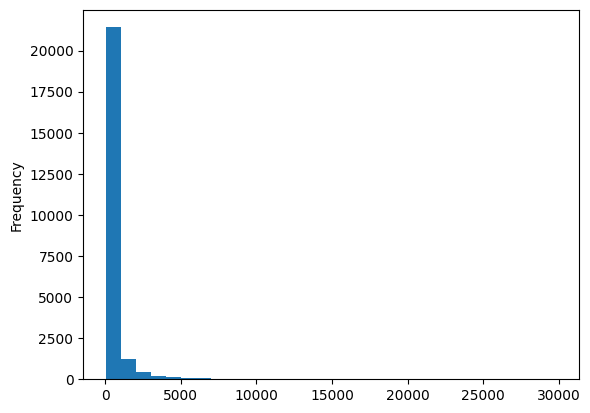

In [11]:
df_colognes['Rating Count'].plot.hist(bins=30)

count    23846.000000
mean       498.820054
std       1422.017520
min         26.000000
25%         56.000000
50%        126.000000
75%        359.000000
max      29858.000000
Name: Rating Count, dtype: float64


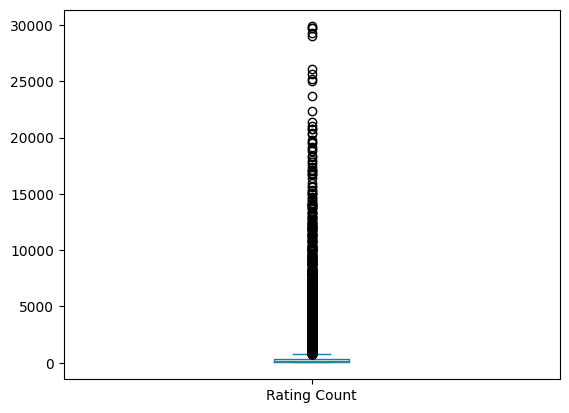

In [12]:
df_colognes['Rating Count'].plot.box()
print(df_colognes['Rating Count'].describe())

<Axes: ylabel='Frequency'>

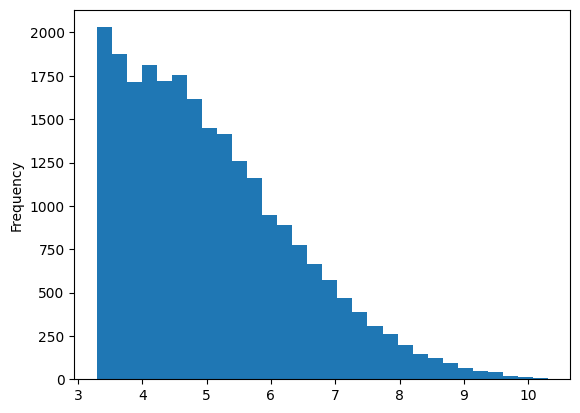

In [13]:
np.log1p(df_colognes['Rating Count']).plot.hist(bins=30)

In [14]:
C = df_colognes['Rating Value'].mean()
m1= df_colognes["Rating Count"].quantile(0.50) #be more forgiving for perfumes with low rating count value
m2= 200
m3= df_colognes["Rating Count"].quantile(0.75) #be less forgiving for perfumes with low rating count value

# Weighted Rating formula
def weighted_rating(row, m, C=C):
    v = row["Rating Count"]
    R = row["Rating Value"]
    return (v / (v + m) * R) + (m / (v + m) * C)

df_colognes["Weighted Rating at Median"] = df_colognes.apply(weighted_rating,m=m1, axis=1)
df_colognes["Weighted Rating at 200"] = df_colognes.apply(weighted_rating,m=m2, axis=1)
df_colognes["Weighted Rating at 3rd Quartile"] = df_colognes.apply(weighted_rating,m=m3, axis=1)

df_colognes[['Weighted Rating at Median','Weighted Rating at 200','Weighted Rating at 3rd Quartile', 'Rating Value', 'Rating Count']]

,Weighted Rating at Median,Weighted Rating at 200,Weighted Rating at 3rd Quartile,Rating Value,Rating Count
6810,3.876128,3.893389,3.913827,3.81,160
974,3.837321,3.875021,3.908840,3.46,41
20994,4.019316,4.000347,3.983938,4.26,31
15643,3.994331,3.984475,3.975159,4.07,57
8559,3.910837,3.921193,3.933299,3.87,152
...,...,...,...,...,...
20936,4.040306,4.016179,3.994163,4.26,46
13074,3.967773,3.965305,3.963177,4.00,30
24038,4.102275,4.056332,4.016897,4.72,29
14641,3.973767,3.969292,3.965496,4.04,26


The Weighted Rating at a minimum `Rating Count` threshold of at least 200 votes seems to be a nice compromise as it can showcase more niche perfumes in the recommendation engine.

In [15]:
df_colognes.drop(['Weighted Rating at Median','Weighted Rating at 3rd Quartile'],axis=1, inplace=True)
df_colognes.rename(columns={'Weighted Rating at 200': 'Weighted Rating'}, inplace=True)

3. Year

In [16]:
# Year impute (brand-aware)
df_colognes["Year"] = pd.to_numeric(df_colognes["Year"], errors="coerce")
brand_year_med = df_colognes.groupby("Brand")["Year"].transform(lambda s: s.fillna(s.median()))
df_colognes["Year_imputed"] = df_colognes["Year"].isna()
df_colognes["Year_filled"] = df_colognes["Year"].fillna(brand_year_med).fillna(df_colognes["Year"].median())
df_colognes[["Year","Year_filled","Year_imputed"]]

,Year,Year_filled,Year_imputed
6810,2011.0,2011.0,False
974,2018.0,2018.0,False
20994,2015.0,2015.0,False
15643,2023.0,2023.0,False
8559,2017.0,2017.0,False
...,...,...,...
20936,NaN,2021.0,True
13074,2022.0,2022.0,False
24038,2023.0,2023.0,False
14641,NaN,2015.0,True


5. Drop Perfumer Columns

In [17]:
df_colognes['Perfumer1'].unique()

array(['unknown', 'christian vermorel', 'nathalie koobus',
       'karine dubreuil-sereni', 'paolo terenzi', 'andy tauer',
       'gino percontino', 'jimmy bodin', 'michel girard',
       'christophe raynaud', 'natalie gracia-cetto', 'sophie labbé',
       'jean kerleo', 'mark constantine', 'bruno jovanovic',
       'luca maffei', 'alexandra monet', 'viola pompili',
       'corinne cachen', 'sidonie lancesseur', 'jérôme epinette',
       'frank voelkl', 'jo malone', 'bertrand duchaufour', 'claude dir',
       'stefano frecceri', 'geza schoen', 'beverley bayne', 'claire cain',
       'olivier cresp', 'ursula wandel', 'aure?lien guichard',
       'annick menardo', 'lucas sieuzac', 'sonia constant', 'martin gras',
       'nadège le garlantezec', 'alienor massenet', 'gerald ghislain',
       'luca gritti', 'daphné bugey', 'nicolas beaulieu',
       'alberto morillas', 'jacques polge', 'olivier polge',
       'rosendo mateu', 'hany hafez', 'theodoros kalotinis',
       'jeanne sandra rance'

In [18]:
df_colognes[df_colognes['Perfumer1'] == 'unknown']['Perfumer1'].count()

np.int64(12214)

Seems like half of the perfumes have missing/unknown perfumers.

Remove perfumer columns.

In [19]:
df_colognes.drop(['Perfumer1','Perfumer2'],axis=1,inplace=True)
df_colognes

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5,Weighted Rating,Year_imputed,Year_filled
6810,https://www.fragrantica.com/perfume/blood-conc...,0,blood-concept,Italy,unisex,3.81,160,2011.0,"raspberry, caraway","cyperus esculentus, rose","leather, metallic notes, birch, virginia cedar",leather,metallic,fruity,smoky,woody,3.893389,False,2011.0
974,https://www.fragrantica.com/perfume/byron-parf...,0-9,byron-parfums,France,unisex,3.46,41,2018.0,"saffron, spicy notes, bergamot",almond,"amber, sandalwood, vanilla",warm spicy,woody,amber,almond,powdery,3.875021,False,2018.0
20994,https://www.fragrantica.com/perfume/blood-conc...,0-absolute-suede,blood-concept,Italy,unisex,4.26,31,2015.0,"thyme, plum, mint","raspberry, styrax, coffee, rosemary","suede, leather, incense, cypriol oil or nagarm...",leather,fruity,amber,aromatic,sweet,4.000347,False,2015.0
15643,https://www.fragrantica.com/perfume/le-monde-g...,000,le-monde-gourmand,USA,unisex,4.07,57,2023.0,"bergamot, freesia",water lily,sandal,woody,floral,citrus,powdery,fresh spicy,3.984475,False,2023.0
8559,https://www.fragrantica.com/perfume/bon-parfum...,001-orange-blossom-petitgrain-bergamot,bon-parfumeur,France,unisex,3.87,152,2017.0,"bergamot, citron, mandarin orange, rosemary","neroli, petitgrain, jasmine, lavender","orange blossom, musk",citrus,white floral,aromatic,fresh spicy,green,3.921193,False,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20936,https://www.fragrantica.com/perfume/milton-llo...,zozo,milton-lloyd,UK,women,4.26,46,NaN,"tuberose, orange blossom","gardenia, aldehydes, rose","powdery notes, sandalwood, amber",white floral,powdery,tuberose,aldehydic,animalic,4.016179,True,2021.0
13074,https://www.fragrantica.com/perfume/dede-arte-...,zucchero-di-neroli,dede-arte-profumata,Italy,unisex,4.00,30,2022.0,"orange blossom, lemon","neroli, cotton candy","benzoin, musk, chamomile",citrus,white floral,sweet,amber,musky,3.965305,False,2022.0
24038,https://www.fragrantica.com/perfume/zimaya/zuk...,zukhruf-pink,zimaya,UAE,women,4.72,29,2023.0,"vanilla, heliotrope, orchid","almond milk, marshmallow, musk","vanilla, sandalwood, amber",powdery,vanilla,sweet,almond,woody,4.056332,False,2023.0
14641,https://www.fragrantica.com/perfume/khalis/zul...,zulfa,khalis,UAE,men,4.04,26,NaN,"mimosa, spicy notes","white rose, citruses",white musk,musky,rose,powdery,citrus,floral,3.969292,True,2015.0


5. Parse Top/Middle/Base Notes.

* Normalize text (lower case,unify quotes, collapse spaces)
* Split on commas into canonical tokens
* Multi-label one-hot per level.

We will keep the one hots sparse.

In [25]:
def parse_notes_cell(x: str) -> List[str]:
    """Lowercase, unify typographic quotes, collapse spaces, split on commas."""
    if not isinstance(x, str):
        return []
    s = x.lower().replace("’","'").replace("`","'").strip()
    s = re.sub(r"\s+", " ", s)
    return [t.strip() for t in s.split(",") if t.strip()]

def extract_level_lists(df: pd.DataFrame) -> Tuple[List[List[str]], List[List[str]], List[List[str]]]:
    top_list = df["Top"].apply(parse_notes_cell).tolist()
    mid_list = df["Middle"].apply(parse_notes_cell).tolist()
    base_list = df["Base"].apply(parse_notes_cell).tolist()
    return top_list, mid_list, base_list

def onehot_multilabel(lists: List[List[str]], suffix: str):
    """Return CSR one-hot matrix and column names for a given level."""
    mlb = MultiLabelBinarizer(sparse_output=True)
    X = mlb.fit_transform(lists)  # CSR
    cols = [f"{c}_{suffix}" for c in mlb.classes_]
    return X.tocsr(), cols, mlb

top_list, mid_list, base_list = extract_level_lists(df_colognes)
X_top, top_cols, _ = onehot_multilabel(top_list,  "top")
X_mid, mid_cols, _ = onehot_multilabel(mid_list,  "mid")
X_base, base_cols, _ = onehot_multilabel(base_list, "base")

print("top: ",top_list[:5],"mid: ",mid_list[:5],"base: ",base_list[:5])

df_colognes['Top'] = top_list
df_colognes['Middle'] = mid_list
df_colognes['Base'] = base_list

print(X_top.shape, X_mid.shape, X_base.shape)
df_colognes

top:  [['raspberry', 'caraway'], ['saffron', 'spicy notes', 'bergamot'], ['thyme', 'plum', 'mint'], ['bergamot', 'freesia'], ['bergamot', 'citron', 'mandarin orange', 'rosemary']] mid:  [['cyperus esculentus', 'rose'], ['almond'], ['raspberry', 'styrax', 'coffee', 'rosemary'], ['water lily'], ['neroli', 'petitgrain', 'jasmine', 'lavender']] base:  [['leather', 'metallic notes', 'birch', 'virginia cedar'], ['amber', 'sandalwood', 'vanilla'], ['suede', 'leather', 'incense', 'cypriol oil or nagarmotha', 'amber'], ['sandal'], ['orange blossom', 'musk']]
(23846, 1184) (23846, 1304) (23846, 901)


,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Year,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5,Weighted Rating,Year_imputed,Year_filled
6810,https://www.fragrantica.com/perfume/blood-conc...,0,blood-concept,Italy,unisex,3.81,160,2011.0,"[raspberry, caraway]","[cyperus esculentus, rose]","[leather, metallic notes, birch, virginia cedar]",leather,metallic,fruity,smoky,woody,3.893389,False,2011.0
974,https://www.fragrantica.com/perfume/byron-parf...,0-9,byron-parfums,France,unisex,3.46,41,2018.0,"[saffron, spicy notes, bergamot]",[almond],"[amber, sandalwood, vanilla]",warm spicy,woody,amber,almond,powdery,3.875021,False,2018.0
20994,https://www.fragrantica.com/perfume/blood-conc...,0-absolute-suede,blood-concept,Italy,unisex,4.26,31,2015.0,"[thyme, plum, mint]","[raspberry, styrax, coffee, rosemary]","[suede, leather, incense, cypriol oil or nagar...",leather,fruity,amber,aromatic,sweet,4.000347,False,2015.0
15643,https://www.fragrantica.com/perfume/le-monde-g...,000,le-monde-gourmand,USA,unisex,4.07,57,2023.0,"[bergamot, freesia]",[water lily],[sandal],woody,floral,citrus,powdery,fresh spicy,3.984475,False,2023.0
8559,https://www.fragrantica.com/perfume/bon-parfum...,001-orange-blossom-petitgrain-bergamot,bon-parfumeur,France,unisex,3.87,152,2017.0,"[bergamot, citron, mandarin orange, rosemary]","[neroli, petitgrain, jasmine, lavender]","[orange blossom, musk]",citrus,white floral,aromatic,fresh spicy,green,3.921193,False,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20936,https://www.fragrantica.com/perfume/milton-llo...,zozo,milton-lloyd,UK,women,4.26,46,NaN,"[tuberose, orange blossom]","[gardenia, aldehydes, rose]","[powdery notes, sandalwood, amber]",white floral,powdery,tuberose,aldehydic,animalic,4.016179,True,2021.0
13074,https://www.fragrantica.com/perfume/dede-arte-...,zucchero-di-neroli,dede-arte-profumata,Italy,unisex,4.00,30,2022.0,"[orange blossom, lemon]","[neroli, cotton candy]","[benzoin, musk, chamomile]",citrus,white floral,sweet,amber,musky,3.965305,False,2022.0
24038,https://www.fragrantica.com/perfume/zimaya/zuk...,zukhruf-pink,zimaya,UAE,women,4.72,29,2023.0,"[vanilla, heliotrope, orchid]","[almond milk, marshmallow, musk]","[vanilla, sandalwood, amber]",powdery,vanilla,sweet,almond,woody,4.056332,False,2023.0
14641,https://www.fragrantica.com/perfume/khalis/zul...,zulfa,khalis,UAE,men,4.04,26,NaN,"[mimosa, spicy notes]","[white rose, citruses]",[white musk],musky,rose,powdery,citrus,floral,3.969292,True,2015.0


For EDA, we will export the clean data as it is right now so it is easier to inspect, visualize, and summarize the data directly.

In [26]:
# Drop original Year column and replace with the Brand aware median year imputed column.
df_colognes.drop(columns=['Year'], inplace=True)
df_colognes.rename(columns={'Year_filled': 'Year'}, inplace=True)

In [30]:
df_colognes

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5,Weighted Rating,Year_imputed,Year
6810,https://www.fragrantica.com/perfume/blood-conc...,0,blood-concept,Italy,unisex,3.81,160,"[raspberry, caraway]","[cyperus esculentus, rose]","[leather, metallic notes, birch, virginia cedar]",leather,metallic,fruity,smoky,woody,3.893389,False,2011.0
974,https://www.fragrantica.com/perfume/byron-parf...,0-9,byron-parfums,France,unisex,3.46,41,"[saffron, spicy notes, bergamot]",[almond],"[amber, sandalwood, vanilla]",warm spicy,woody,amber,almond,powdery,3.875021,False,2018.0
20994,https://www.fragrantica.com/perfume/blood-conc...,0-absolute-suede,blood-concept,Italy,unisex,4.26,31,"[thyme, plum, mint]","[raspberry, styrax, coffee, rosemary]","[suede, leather, incense, cypriol oil or nagar...",leather,fruity,amber,aromatic,sweet,4.000347,False,2015.0
15643,https://www.fragrantica.com/perfume/le-monde-g...,000,le-monde-gourmand,USA,unisex,4.07,57,"[bergamot, freesia]",[water lily],[sandal],woody,floral,citrus,powdery,fresh spicy,3.984475,False,2023.0
8559,https://www.fragrantica.com/perfume/bon-parfum...,001-orange-blossom-petitgrain-bergamot,bon-parfumeur,France,unisex,3.87,152,"[bergamot, citron, mandarin orange, rosemary]","[neroli, petitgrain, jasmine, lavender]","[orange blossom, musk]",citrus,white floral,aromatic,fresh spicy,green,3.921193,False,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20936,https://www.fragrantica.com/perfume/milton-llo...,zozo,milton-lloyd,UK,women,4.26,46,"[tuberose, orange blossom]","[gardenia, aldehydes, rose]","[powdery notes, sandalwood, amber]",white floral,powdery,tuberose,aldehydic,animalic,4.016179,True,2021.0
13074,https://www.fragrantica.com/perfume/dede-arte-...,zucchero-di-neroli,dede-arte-profumata,Italy,unisex,4.00,30,"[orange blossom, lemon]","[neroli, cotton candy]","[benzoin, musk, chamomile]",citrus,white floral,sweet,amber,musky,3.965305,False,2022.0
24038,https://www.fragrantica.com/perfume/zimaya/zuk...,zukhruf-pink,zimaya,UAE,women,4.72,29,"[vanilla, heliotrope, orchid]","[almond milk, marshmallow, musk]","[vanilla, sandalwood, amber]",powdery,vanilla,sweet,almond,woody,4.056332,False,2023.0
14641,https://www.fragrantica.com/perfume/khalis/zul...,zulfa,khalis,UAE,men,4.04,26,"[mimosa, spicy notes]","[white rose, citruses]",[white musk],musky,rose,powdery,citrus,floral,3.969292,True,2015.0


In [32]:
df_colognes.to_csv('../../data/processed/perfumes_eda.csv',sep=';',index=False,encoding='ISO-8859-1')

Moving onto accords.

* Sort accords by rank by assigning position weights
* Build a weighted multi-hot CSR matrix where each accord column receives the weight from its rank position.

In [34]:
from scipy.sparse import csr_matrix

def accords_rank_aware_matrix(
        df : pd.DataFrame,
        position_weights : List[float] = [1.0,0.8,0.6,0.4,0.2],
) -> Tuple[csr_matrix,List[str]]:
    """
    Build a weighted CSR matrix for accords.
    Each row i: for each accord position p with value v, add weight w[p] to column v.
    """
    accord_cols = [f"mainaccord{i+1}" for i in range(5)]
    if not accord_cols:
        # empty matrix if nothing found
        return csr_matrix((len(df), 0), dtype=np.float32), []

    #Collect unique accords
    vocab = {}
    for _, row in df[accord_cols].iterrows():
        for v in row.values:
            if pd.isna(v) or not str(v).strip():
                continue
            name = str(v).strip().lower()
            if name not in vocab:
                vocab[name] = len(vocab)
    n_rows = len(df)
    n_cols = len(vocab)
    rows, cols, data = [], [],[]

    w = list(position_weights)
    w = w[:len(accord_cols)]

    # add weighted entries
    for i, (_, row) in enumerate(df[accord_cols].iterrows()):
        for p, col_name in enumerate(accord_cols):
            v = row[col_name]
            if pd.isna(v) or not str(v).strip():
                continue
            name = str(v).strip().lower()
            j = vocab[name]
            weight = float(w[p])
            if weight != 0.0:
                rows.append(i)
                cols.append(j)
                data.append(weight)

    X = csr_matrix((data, (rows, cols)), shape=(n_rows, n_cols), dtype=np.float32)
    col_names = [f"accord_{name}" for name, _ in sorted(vocab.items(), key=lambda kv: kv[1])]
    return X, col_names

X_acc, acc_cols = accords_rank_aware_matrix(df_colognes, position_weights=[1.0, 0.8, 0.6, 0.4, 0.2])
X_acc.shape, acc_cols[:10]

((23846, 84),
 ['accord_leather',
  'accord_metallic',
  'accord_fruity',
  'accord_smoky',
  'accord_woody',
  'accord_warm spicy',
  'accord_amber',
  'accord_almond',
  'accord_powdery',
  'accord_aromatic'])

Lets standardize the Weighted Rating, Rating Count, and Year columns to z-scores and stack them into a dense matrix.

In [35]:
def z_score(x:np.ndarray) -> np.ndarray:
    mu, sd = x.mean(), x.std()
    if sd==0:
        sd=1.0
    return (x-mu)/sd

def meta_matrix(d:pd.DataFrame):
    q = pd.to_numeric(d['Weighted Rating'], errors='coerce')
    cnt = pd.to_numeric(d['Rating Count'], errors='coerce')
    yr = pd.to_numeric(d['Year'], errors='coerce')

    weighted_rating_z = z_score(q.astype(float))
    log_count_z = z_score(np.log1p(cnt.astype(float)))
    recency_z = z_score(yr.astype(float))

    M = np.vstack([weighted_rating_z,log_count_z,recency_z]).T
    cols = ['weighted_rating_z','log_count_z','recency_z']
    return M, cols

M_meta, meta_cols = meta_matrix(df_colognes)
M_meta.shape , meta_cols

((23846, 3), ['weighted_rating_z', 'log_count_z', 'recency_z'])

In [36]:
df_colognes

,url,Perfume,Brand,Country,Gender,Rating Value,Rating Count,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5,Weighted Rating,Year_imputed,Year
6810,https://www.fragrantica.com/perfume/blood-conc...,0,blood-concept,Italy,unisex,3.81,160,"[raspberry, caraway]","[cyperus esculentus, rose]","[leather, metallic notes, birch, virginia cedar]",leather,metallic,fruity,smoky,woody,3.893389,False,2011.0
974,https://www.fragrantica.com/perfume/byron-parf...,0-9,byron-parfums,France,unisex,3.46,41,"[saffron, spicy notes, bergamot]",[almond],"[amber, sandalwood, vanilla]",warm spicy,woody,amber,almond,powdery,3.875021,False,2018.0
20994,https://www.fragrantica.com/perfume/blood-conc...,0-absolute-suede,blood-concept,Italy,unisex,4.26,31,"[thyme, plum, mint]","[raspberry, styrax, coffee, rosemary]","[suede, leather, incense, cypriol oil or nagar...",leather,fruity,amber,aromatic,sweet,4.000347,False,2015.0
15643,https://www.fragrantica.com/perfume/le-monde-g...,000,le-monde-gourmand,USA,unisex,4.07,57,"[bergamot, freesia]",[water lily],[sandal],woody,floral,citrus,powdery,fresh spicy,3.984475,False,2023.0
8559,https://www.fragrantica.com/perfume/bon-parfum...,001-orange-blossom-petitgrain-bergamot,bon-parfumeur,France,unisex,3.87,152,"[bergamot, citron, mandarin orange, rosemary]","[neroli, petitgrain, jasmine, lavender]","[orange blossom, musk]",citrus,white floral,aromatic,fresh spicy,green,3.921193,False,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20936,https://www.fragrantica.com/perfume/milton-llo...,zozo,milton-lloyd,UK,women,4.26,46,"[tuberose, orange blossom]","[gardenia, aldehydes, rose]","[powdery notes, sandalwood, amber]",white floral,powdery,tuberose,aldehydic,animalic,4.016179,True,2021.0
13074,https://www.fragrantica.com/perfume/dede-arte-...,zucchero-di-neroli,dede-arte-profumata,Italy,unisex,4.00,30,"[orange blossom, lemon]","[neroli, cotton candy]","[benzoin, musk, chamomile]",citrus,white floral,sweet,amber,musky,3.965305,False,2022.0
24038,https://www.fragrantica.com/perfume/zimaya/zuk...,zukhruf-pink,zimaya,UAE,women,4.72,29,"[vanilla, heliotrope, orchid]","[almond milk, marshmallow, musk]","[vanilla, sandalwood, amber]",powdery,vanilla,sweet,almond,woody,4.056332,False,2023.0
14641,https://www.fragrantica.com/perfume/khalis/zul...,zulfa,khalis,UAE,men,4.04,26,"[mimosa, spicy notes]","[white rose, citruses]",[white musk],musky,rose,powdery,citrus,floral,3.969292,True,2015.0


Stack the full weighted sparse matrix after block normalizing.

In [38]:
w_top, w_mid, w_base = 0.35, 0.40, 0.25
w_accord, w_meta = 0.80, 0.20

feature_names = (
    list(top_cols) + list(mid_cols) + list(base_cols) +
    list(acc_cols) + list(meta_cols)
)

def l2_row_normalize_csr(X: sparse.csr_matrix) -> sparse.csr_matrix:
    rn = np.sqrt(X.power(2).sum(axis=1)).A1
    rn[rn == 0.0] = 1.0
    return X.multiply(1.0 / rn[:, None])

# Build blocks
X_notes = sparse.hstack([w_top * X_top, w_mid * X_mid, w_base * X_base]).tocsr()
X_accum = X_acc.tocsr()
X_meta_dense = sparse.csr_matrix(M_meta)  # already z-scored per feature

# Row-normalize each block so one block can't dominate by scale
X_notes = l2_row_normalize_csr(X_notes)
X_accum = l2_row_normalize_csr(X_accum) * w_accord
X_meta_norm = l2_row_normalize_csr(X_meta_dense) * w_meta

# Final stack
X_sparse = sparse.hstack([X_notes, X_accum, X_meta_norm]).tocsr()

X_sparse.shape, len(feature_names), feature_names

((23846, 3476),
 3476,
 ['absinthe_top',
  'acai berry_top',
  'acerola_top',
  'acetylfuran_top',
  'acácia_top',
  'african freesia petals_top',
  'african geranium_top',
  'african ginger_top',
  'african orange flower_top',
  'african violet_top',
  'agarwood_top',
  'agarwood (oud)_top',
  'agave_top',
  'agave nectar_top',
  'aglaia_top',
  'aldehydes_top',
  'algae_top',
  'algerian geranium_top',
  'allspice_top',
  'almond_top',
  'almond blossom_top',
  'almond milk_top',
  'almond tree_top',
  'almond wood_top',
  'aloe vera_top',
  'aluminum_top',
  'amalfi lemon_top',
  'amaretto_top',
  'amaryllis_top',
  'amazon lily_top',
  'amber_top',
  'amber xtreme_top',
  'ambergris_top',
  'amberwood_top',
  'ambrarome_top',
  'ambrette_top',
  'ambrette (musk mallow)_top',
  'ambrettolide_top',
  'ambrox super_top',
  'ambroxan_top',
  'american apple_top',
  'amyl salicylate_top',
  'amyris_top',
  'angelica_top',
  'angelica root_top',
  'animal notes_top',
  'anise_top',
  'an

Create artifacts for the recommendation engine.

1. Items artifact: Needed for UI filters in app and details panel.
2. fragrance note bridge: an exploded view of Top/Mid/Base. Needed for explainability "Recommended because you liked ...(top) and ...(base)".
3. X_sparse (model feature matrix): input for PCA/AE/kNN. Saves memory/IO and keeps training reproducible.
4. feature meta: Guarantees column order and meaning of every index. Lets us build a preference vector from user text.
5. EDA compliant dataset: Best for human interpretability .

All of these artifacts will be used in the application to reduce latency at runtime and makes the recommender stateless and portable.

In [39]:
from pathlib import Path

ART = Path('../../data/processed')

def make_id(r):
    b, p = str(r['Brand']).strip(), str(r['Perfume']).strip()
    y = r['Year']
    return f"{b}|{p}|{int(y)}"

df_colognes['fragrance_id'] = df_colognes.apply(make_id, axis=1)

items_cols = [
    "fragrance_id","url","Brand","Perfume","Gender","Year",
    "mainaccord1","mainaccord2","mainaccord3","mainaccord4","mainaccord5",
    "Rating Count","Weighted Rating","Year_imputed"
]

# Items table for app filters/explanations
items = df_colognes[items_cols].copy()
items.to_parquet(ART/'items.parquet',index=False)


# Notes bridge for eda/explanations
def _to_bridge(level_col,level_name):
    if level_col not in df_colognes.columns:
        return pd.DataFrame(columns=['fragrance_id','note','level'])
    s = df_colognes[['fragrance_id',level_col]].explode(level_col)
    s = s.rename(columns={level_col:'note'}).dropna()
    s['note'] = s['note'].astype(str).str.strip()
    s = s[s['note'].ne('') & (s['note'].str.lower()!='nan')]
    s['level'] = level_name
    return s[['fragrance_id','note','level']]

bridge = pd.concat([
    _to_bridge('Top','top'),
    _to_bridge('Middle','mid'),
    _to_bridge('Base','base'),
],ignore_index=True)
bridge.to_parquet(ART/'fragrance_note_bridge.parquet',index=False)

# Save sparse matrix
sparse.save_npz(ART/'X_sparse.npz',X_sparse)

#Save features manifest
feature_meta = {
    'top_mlb_classes': [c.replace('_top','') for c in top_cols],
    'mid_mlb_classes': [c.replace('_mid','') for c in mid_cols],
    'base_mlb_classes': [c.replace('_base','') for c in base_cols],
    'accord_vocab': [c.replace('accord_','') for c in acc_cols],
    'accord_cols' : acc_cols,
    'meta_cols' : meta_cols,
    'weights' : {'notes':{'top':0.35,'mid':0.40,'base':0.25}, 'accord': 0.80, 'meta': 0.20},
    'row_index': df_colognes[['fragrance_id','Brand','Perfume','Year']].to_dict(orient='records'),
    'feature_names': feature_names
}
(ART/'feature_meta.json').write_text(json.dumps(feature_meta,indent=2))

3946096

This concludes the Data Cleaning and Creation part of the project. Next is the EDA to be performed.